In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt

import time
import pickle

In [3]:
batch_size=128
epochs = 1000
log_interval = 100
z_dim = 20

In [10]:
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector -- NOT USED """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2, use only 
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    return I.astype(np.float)

In [11]:
def is_in_arr_list(arr, arr_list):
    for element in arr_list:
        if np.array_equal(element, arr):
            return True
        
    return False

In [17]:
class PongFrames(torch.utils.data.Dataset):
    """
    A customized data set for pong images.
    """
    def __init__(self, _len, discard_duplicates=False, preprocess=False):
        """ Intialize the dataset
        """
        self.transform = transforms.ToTensor()
        self.len = _len
        self.obs = []
        env = gym.make("Pong-v0")
        env.reset()
        for i in range(self.len):
            observation,_,done,_ = env.step(env.action_space.sample())
            if done:
                observation = env.reset()
            present=False
            if discard_duplicates:
                while is_in_arr_list(observation, self.obs):
                    #print(i, "repeat")
                    observation,_,done,_ = env.step(env.action_space.sample())
                    if done:
                        observation = env.reset()
            if not preprocess:
                self.obs.append(observation)
            else:
                self.obs.append(prepro(observation))
        
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image = self.obs[index]
        #return self.transform(image)
        return image
        
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [45]:
use_mixed = False
discard_duplicates = True
preproc = False
n_train_examples = 5000
n_test_examples = 450

## Set up data set and data loader
pong_frames = PongFrames(n_train_examples, discard_duplicates=discard_duplicates, preprocess=preproc)
pong_frames_test = PongFrames(n_test_examples, preprocess=preproc)
#im_dm = pong_frames[0].view(-1).size()[0]
im_dm = pong_frames[0].size

train_loader = torch.utils.data.DataLoader(
    pong_frames,
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    pong_frames_test,
    batch_size=batch_size, shuffle=True)

im_dims = pong_frames[0].shape

In [46]:
from sklearn.decomposition import PCA

In [184]:
n_c = 200

In [185]:
pca = PCA(n_components=n_c)

In [186]:
X = np.array(pong_frames[:])
pca.fit(X.reshape((n_train_examples,-1)))

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

## Using Preprocessed frames as input

In [212]:
total_rewards_pp = []

In [213]:
# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 60 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

render = False 
#render = True

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
#while True:
start = time.time()
while(episode_number < 100):
    if render: env.render()

    # preprocess the observation, set input to network to be difference image
    
    #start = time.time()
    cur_x = prepro(observation)
    #end = time.time()
    #print(end - start)
    
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    #print(x.shape)
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

    # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was ' + str(reward_sum) + '. running mean: {0:.2f}'.format(running_reward))

        if episode_number % 100 == 0: pickle.dump(model, open('save_prepoc.p', 'wb'))
        total_reward += reward_sum
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None

    #if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        #print ('ep ' + str(episode_number) + ': game finished, reward: ' + str(reward) + ('' if reward == -1 else ' !!!!!!!!'))
        #print(episode_number, reward)

end = time.time()
print(end - start)
total_rewards_pp.append(total_rewards)

resetting env. episode reward total was -20.0. running mean: -20.00
resetting env. episode reward total was -20.0. running mean: -20.00
resetting env. episode reward total was -21.0. running mean: -20.01
resetting env. episode reward total was -19.0. running mean: -20.00
resetting env. episode reward total was -21.0. running mean: -20.01
resetting env. episode reward total was -20.0. running mean: -20.01
resetting env. episode reward total was -21.0. running mean: -20.02
resetting env. episode reward total was -19.0. running mean: -20.01
resetting env. episode reward total was -20.0. running mean: -20.01
resetting env. episode reward total was -20.0. running mean: -20.01
resetting env. episode reward total was -21.0. running mean: -20.02
resetting env. episode reward total was -20.0. running mean: -20.02
resetting env. episode reward total was -20.0. running mean: -20.02
resetting env. episode reward total was -21.0. running mean: -20.03
resetting env. episode reward total was -21.0. r

NameError: name 'total_rewards' is not defined

## Using principal components as input
Seems like there is enough info to learn off of

In [106]:
total_rewards_pca = []

In [107]:
# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 60 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

render = False 
#render = True

# model initialization
D = n_c # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
#while True:
start = time.time()
total_reward = 0
while(episode_number < 100):
    if render: env.render()

    # preprocess the observation, set input to network to be difference image
    #start = time.time()
    cur_x = pca.transform(observation.reshape(1,-1)).reshape(-1)
    #end = time.time()
    #print(end - start)
    
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    #print(x.shape)
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

    # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

        # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('Resetting env. episode {}, reward total was '.format(episode_number) + str(reward_sum) + '. running mean: {0:.2f}'.format(running_reward))

        if episode_number % 100 == 0: pickle.dump(model, open('save_prepoc.p', 'wb'))
        total_reward = reward_sum
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None

    #if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        #print ('ep ' + str(episode_number) + ': game finished, reward: ' + str(reward) + ('' if reward == -1 else ' !!!!!!!!'))
        #print(episode_number, reward)

end = time.time()
print(end - start, reward_sum)
total_rewards_pca.append(total_reward)

Resetting env. episode1 reward total was -20.0. running mean: -20.00
Resetting env. episode2 reward total was -21.0. running mean: -20.01
Resetting env. episode3 reward total was -20.0. running mean: -20.01
Resetting env. episode4 reward total was -21.0. running mean: -20.02
Resetting env. episode5 reward total was -21.0. running mean: -20.03
Resetting env. episode6 reward total was -21.0. running mean: -20.04
Resetting env. episode7 reward total was -21.0. running mean: -20.05
Resetting env. episode8 reward total was -21.0. running mean: -20.06
Resetting env. episode9 reward total was -21.0. running mean: -20.07
Resetting env. episode10 reward total was -20.0. running mean: -20.07
Resetting env. episode11 reward total was -20.0. running mean: -20.07
Resetting env. episode12 reward total was -21.0. running mean: -20.08
Resetting env. episode13 reward total was -21.0. running mean: -20.09
Resetting env. episode14 reward total was -19.0. running mean: -20.07
Resetting env. episode15 rewa

In [100]:
np.sum(pca.explained_variance_ratio_)

0.68515199189031983

### If I modify one of the PCs and reconstruct, I should be able to see what kind of effect it has, and get an intuition as to what each represents

In [187]:
g = pca.transform(observation.reshape(1,-1))
x_hat = np.clip(pca.inverse_transform(g).reshape(210,160,3), 0, 255)

In [203]:
g2 = pca.transform(observation2.reshape(1,-1))
x_hat2 = np.clip(pca.inverse_transform(g2).reshape(210,160,3), 0, 255)

In [190]:
loss = ((observation - x_hat) ** 2).mean()

In [191]:
loss

6.920626950494654

In [114]:
%matplotlib inline

In [118]:
np.min(x_hat)

-3.38761965109581e-10

In [119]:
np.clip

In [117]:
np.max(x_hat)

233.42715400647521

In [139]:
#env.reset()

In [202]:
observation2,_,_,_ = env.step(0)

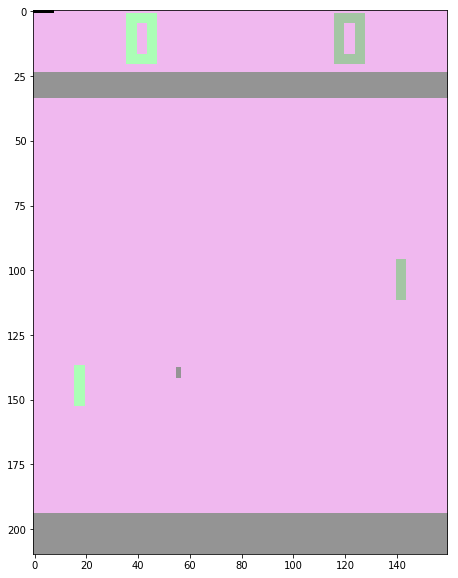

In [201]:
plt.figure(figsize=(10,10))
plt.imshow((observation + observation)/2)
#plt.imshow(observation)

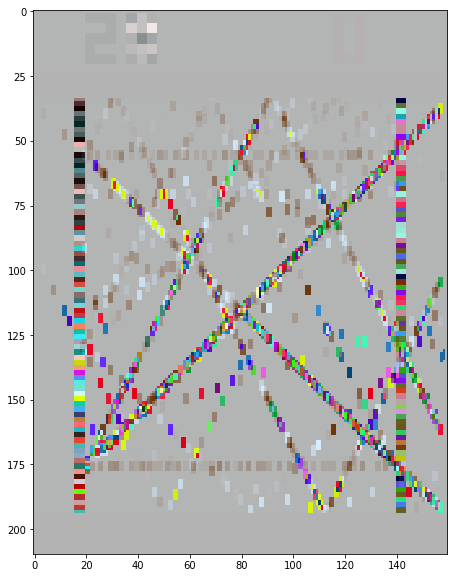

In [204]:
plt.figure(figsize=(10,10))
plt.imshow(x_hat2 - x_hat + x_hat.mean(), cmap="plasma")
#plt.imshow(observation)

In [193]:
x_hat.mean()

98.08631983244976

In [194]:
observation.mean()

98.104285714285709

In [76]:
start = time.time()
_ = observation * observation
end = time.time()
print(end - start)

0.0001480579376220703


In [188]:
pca.explained_variance_ratio_.sum()

0.94563590078542992

In [77]:
??pca.transform(observation.reshape(1,-1))

In [86]:
start = time.time()
cur_x = np.dot(observation.reshape(1,-1), T)
end = time.time()
print(end - start)

0.004439830780029297


In [210]:
??pca.transform